## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
df = pd.read_csv('CreditScoring.csv')

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
#Revisar
numerical = ['seniority', 'time', 'age', 'expenses','income', 'assets', 'debt', 'amount', 'price']
categorical = ['home', 'marital', 'records', 'job', 'default']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [9]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_full_train = df_full_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

y_full_train = df_full_train.default.values
y_test = df_test.default.values
y_train = df_train.default.values
y_val = df_val.default.values

del df_full_train['default']
del df_test['default']
del df_val['default']
del df_train['default']


In [10]:
len(df_train), len(df_val), len(df_test), len(df_full_train)

(2672, 891, 891, 3563)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [11]:
from sklearn.metrics import roc_auc_score
for variable in numerical:
    score = roc_auc_score(y_train, df_train[variable])
    if score  < 0.5:
        score = roc_auc_score(y_train, -df_train[variable])
    print(f"For {variable} the score is: {round(score,3)}")

For seniority the score is: 0.709
For time the score is: 0.561
For age the score is: 0.573
For expenses the score is: 0.501
For income the score is: 0.682
For assets the score is: 0.649
For debt the score is: 0.505
For amount the score is: 0.591
For price the score is: 0.504


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

Seniority

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
columns_subset = ['seniority', 'income', 'assets', 'records', 'job', 'home']

def train(df_train, y_train, C = 1.0):
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[columns_subset].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df_val, dv, model):
    val_dict = df_val[columns_subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = model.predict_proba(X_val)[:, 1]
    
    return y_pred

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [13]:
dv, model = train(df_train[columns_subset], y_train)
y_pred = predict(df_val, dv, model)
round(roc_auc_score(y_val, y_pred),3)

0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encoun

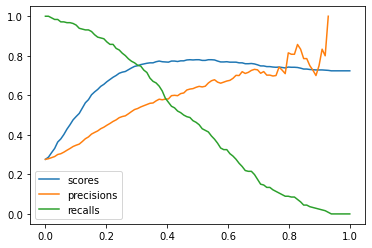

In [14]:
from sklearn.metrics import accuracy_score
thresholds = np.linspace(0, 1, 100)

def precision_and_recall(t,y_val,y_pred):
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0) 
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    return p,r

scores = []
precisions = []
recalls = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)
    p,r = precision_and_recall(t,y_val,y_pred)
    precisions.append(p)
    recalls.append(r)
    
plt.plot(thresholds, scores, label='scores')
plt.plot(thresholds, precisions, label='precisions')
plt.plot(thresholds, recalls, label='recalls')
plt.legend()
plt.show()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

0.4

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [15]:
def f1_score(p,r):
    f1 = 2*((p*r)/(p+r))
    return f1

C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)
C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5188/3978768677.py:13: RuntimeWarning: invalid value encoun

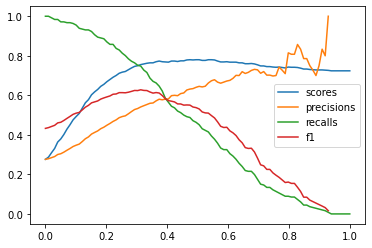

In [16]:
scores = []
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)
    p,r = precision_and_recall(t,y_val,y_pred)
    precisions.append(p)
    recalls.append(r)
    f1 = f1_score(p,r)
    f1_scores.append(f1)
    
    
plt.plot(thresholds, scores, label='scores')
plt.plot(thresholds, precisions, label='precisions')
plt.plot(thresholds, recalls, label='recalls')
plt.plot(thresholds, f1_scores, label='f1')
plt.legend()
plt.show()

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

0.3

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [17]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]
    

    dv, model = train(df_train, y_train, C = 1)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % ( np.mean(scores), np.std(scores)))

0.814 +- 0.015


In [18]:
df_train.head(15)

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,5,private,60,24,married,no,fixed,45,127,2000,0,1000,1282
1,14,parents,60,32,married,yes,fixed,35,140,0,0,1150,1273
2,25,owner,12,43,married,no,freelance,75,250,100000,0,600,841
3,18,rent,60,37,married,no,fixed,70,100,0,0,1300,1345
4,1,parents,48,24,single,yes,fixed,35,65,0,0,900,1061
5,3,owner,60,32,married,no,fixed,45,90,6000,0,1500,2502
6,10,rent,48,39,married,no,fixed,51,163,0,0,880,1345
7,7,owner,24,39,married,no,fixed,75,260,10000,0,400,1100
8,2,private,36,32,married,no,fixed,75,80,2500,0,1300,1813
9,1,parents,60,35,single,no,fixed,35,75,0,0,1340,1350


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

0.014

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [19]:
!pip install tqdm
from tqdm.auto import tqdm

In [20]:
for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.5f +- %.5f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.80769 +- 0.01183
C=0.1 0.81289 +- 0.01374
C=1 0.81417 +- 0.01461
C=10 0.81415 +- 0.01461


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

C = 10

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.